# Botswana Antenna Position Calibration

Author: Tim Molteno. tim@elec.ac.nz.

The antennas are laid out on five spiral arms.  This notebook will use measurements to infer the actual layout of the antennas.

The other reference point is the center of the array. This is assumed to be the point [0,0]. Make sure that a marker is present at this reference point at the same height as the level of the antennas (otherwise the distances will be wrong).

In [1]:
import numpy as np
from scipy.optimize import minimize 

In [2]:
x0 = [0,0]
global_rot_degrees = -35.07826156287494

In [3]:
# pip install pandas
# pip install odfpy

import pandas as pd

cols = [f"A {i}" for i in range(24)]
data = pd.read_excel('antenna_measurements.ods', "Sheet1", usecols=cols)
radius = data.loc[0]
radius

A 0      315.0
A 1      805.0
A 2     1188.0
A 3     1407.0
A 4     1677.0
A 5      314.0
A 6      802.0
A 7     1179.0
A 8     1400.0
A 9     1668.0
A 10     313.0
A 11     800.0
A 12    1183.0
A 13    1405.0
A 14    1674.0
A 15     315.0
A 16     800.0
A 17    1177.0
A 18    1397.0
A 19    1665.0
A 20     320.0
A 21     810.0
A 22    1188.0
A 23    1410.0
Name: 0, dtype: float64

## Finding the antennas

This is done by measuring the distance from each antenna to x0 as well as each other antenna. The distance $m_0$ are the measurements to $x_0$. The array m_ij are the distances between antennas.

In [4]:
n_ant = 24
m_0 = np.zeros(24)
m_ij = np.zeros((24,24))

radius = data.loc[0]

for i in range(24):
    m_ij[i,:] = data.loc[i+1]

The following are the measured distances from [x1, x0, x2] from the reference points in millimeters. Note that their order must be the same as the order of the variable called 'reference_points'. In this case, they are x1,x0,x2.

In [5]:
for i in range(n_ant):
    for j in range(n_ant):
        if not np.isnan(m_ij[i,j]):
            m_ij[j,i] = m_ij[i,j]

m_ij


array([[  nan,  498.,  893., 1130., 1438.,  390.,  833., 1245., 1503.,
        1825.,  610., 1097., 1495., 1730., 1992.,  600., 1055., 1399.,
        1570., 1790.,  373.,  730., 1033., 1214.],
       [ 498.,   nan,  419.,  690., 1055.,  747.,  998., 1396., 1679.,
        2048., 1065., 1540., 1950., 2198., 2481., 1100., 1530., 1830.,
        1970., 2130.,  806.,  942., 1061., 1129.],
       [ 893.,  419.,   nan,  285.,  675., 1054., 1133., 1470., 1752.,
        2160., 1400., 1846., 2265., 2529., 2838., 1499., 1940., 2240.,
        2390., 2535., 1220., 1332., 1379., 1375.],
       [1130.,  690.,  285.,   nan,  409., 1230., 1195., 1474., 1745.,
        2154., 1580., 1994., 2415., 2689., 3020., 1720., 2190., 2505.,
        2660., 2810., 1480., 1616., 1658., 1639.],
       [1438., 1055.,  675.,  409.,   nan, 1441., 1267., 1437., 1676.,
        2090., 1794., 2145., 2559., 2840., 3197., 1999., 2470., 2820.,
        3001., 3170., 1800., 2000., 2060., 2040.],
       [ 390.,  747., 1054., 1230.,

## Plot the Initial Guess Points

Initial Guesses are from JSON queried from the telescope API. These are converted to millimeters.

In [8]:
import json
import requests

def get_data(path):
    server = "https://api.elec.ac.nz/tart/bw-biust/"

    r = requests.get('{}/{}'.format(server, path))
    return json.loads(r.text)

def get_pos():
    return np.array(get_data('api/v1/imaging/antenna_positions'))

if True:
    with open('ispiral_24/ispiral_24_opt.json', "r") as f:
        data = f.read()
    cal_json = json.loads(data)
    current_pos = cal_json["ant_pos"]
    current_pos = np.array(current_pos)
else:
    current_pos = get_pos()
    json_result = {}
    json_result["antenna_positions"] = current_pos.tolist()
    print(json.dumps(json_result, indent=4, separators=(',', ': ')))


14.002541343213675 310.0014609128154
235.13248980941378 763.1201118529664
720.6185568638982 937.4574815521081
1115.5339451367217 848.3140185087698
1380.8174763256088 682.2252314869799
299.15593270164123 82.47851151396529
798.4302903744532 12.192796685930565
1114.25842711267 -395.65868096508
1151.5135220166703 -798.7923793850056
1075.5308183012016 -1102.4162681528405
170.88599300257678 -259.0269374556853
258.32456728944646 -755.5845490831442
-31.96897665727074 -1181.9879943324784
-403.8594500253187 -1341.9948589231042
-716.1028746674791 -1363.5559549562533
-193.54258082477207 -242.56596286337205
-638.7769276604661 -479.16972939357674
-1134.0163412724153 -334.85007382670995
-1401.112388810157 -30.60605615709238
-1518.1067342872097 259.692342427555
-290.50188622265966 109.11292789227643
-653.1104198128471 459.4413699378243
-668.8916660468823 975.0392675721602
-462.0756283179156 1323.0792759564329


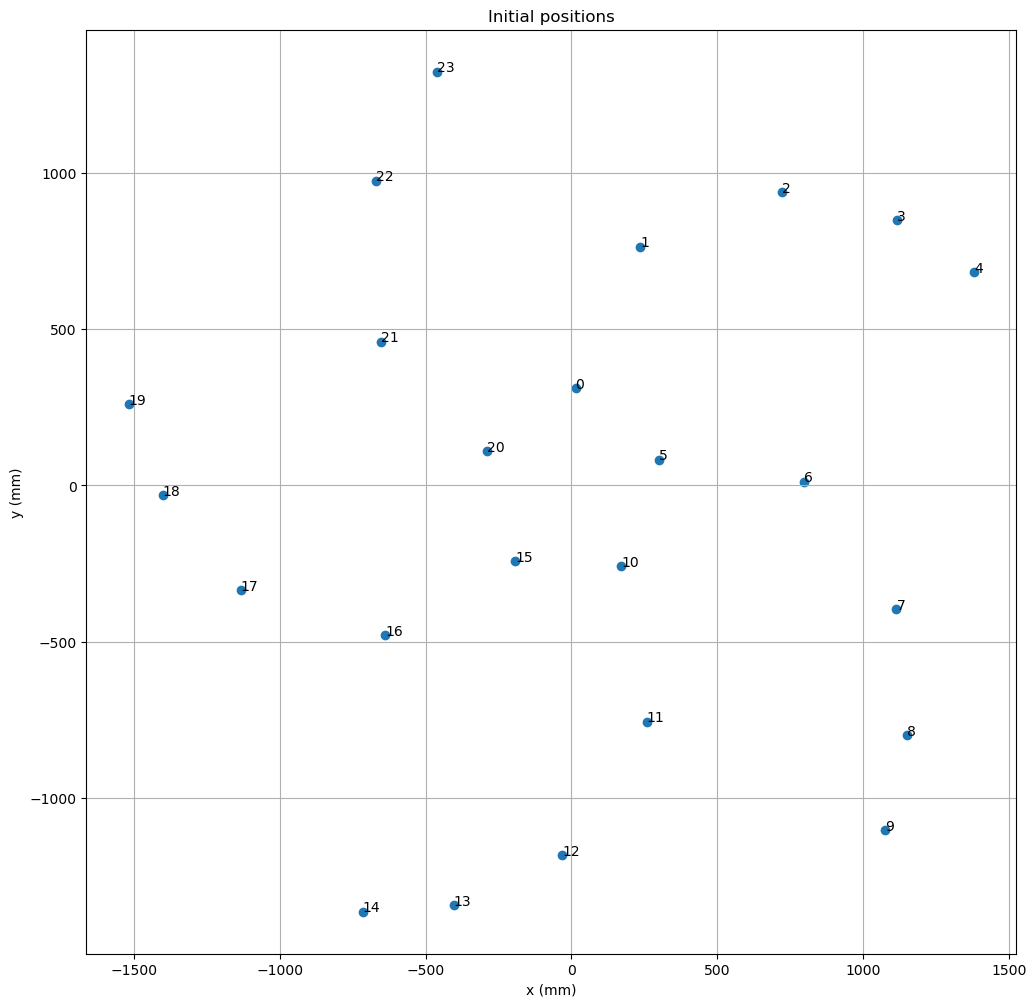

In [9]:
def i_y(i):
    return 2*i+1

def i_x(i):
    return 2*i


initial_guess = np.zeros(2*n_ant)

for i in range(n_ant):
    x,y = current_pos[i][0:2]*1000
    initial_guess[i_x(i)] = x
    initial_guess[i_y(i)] = y
    
    print(x,y)
initial_guess

pos_i = current_pos*1000
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(pos_i[:,0], pos_i[:,1])
for i in range(0,pos_i.shape[0]):
    ax.text(pos_i[i,0], pos_i[i,1],f"{i}")

ax.grid(True)
ax.set_title('Initial positions')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
plt.savefig('initial_positions.png')
plt.show()

## Criteria for Optimality

The function below is minimized when the positions (in variable x) are consistent with the measured distances m[i,j]. The initial value of this function is more than 3 million.

Note that the x input is a 1D vector of with 48 entries as [p0.x, p0.y, p1.x, p1.y]

In [10]:
def dist(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)


def p(x, i):
    return [x[i_x(i)],x[i_y(i)]]

max_err = 1200
def bounds():
    ret = [(0,0)]*48
    for i in range(24):
        _x,_y = pos_i[i,0], pos_i[i,1]
        ret[i_x(i)] = (_x - max_err, _x + max_err)
        ret[i_y(i)] = (_y - max_err, _y + max_err)
    # x-component of the north arm set to zero.
    #for i in [0,1,2,3,4]:
    #    xval = pos_i[i,0]
    #    ret[i_x(i)] = ( - 2, + 2)
    
    return ret

bnd = bounds()

center = [0,0]

def angle(x, i):
    _x, _y = p(x, i)
    return np.degrees(np.arctan2(_y,_x)) - 90
    
def radius_model(x):
    ret = []
    
    for i in range(n_ant):
        p_i = p(x,i)
        ret.append(dist(center, p_i))
        
    return np.array(ret)

non_nan_ij = []
non_nan_indices = []
for i in range(n_ant):
    for j in range(n_ant):
        if not np.isnan(m_ij[i,j]):
            non_nan_ij.append(m_ij[i,j])
            non_nan_indices.append([i,j])
non_nan_ij = np.array(non_nan_ij)
non_nan_indices = np.array(non_nan_indices)

def m_ij_model(x):
    ret = []
    for i in range(n_ant):
        p_i = p(x,i)

        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret.append(dist(p_j, p_i))
                
    return np.array(ret)
    
def radius_residual(x):
    predict = radius_model(x)
    return predict - radius

def m_ij_residual(x):
    predict = m_ij_model(x)
    return predict - non_nan_ij

def rot_residual(x):
    predict = angle(x, 3)
    return predict - 0

def f_old(x):
    ret = 0
    for i in range(n_ant):
        p_i = p(x,i)
        ret += (dist(center, p_i) - m_0[i])**2
        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret += (dist(p_j, p_i) - m_ij[i,j])**2
    return ret

def f(x):
    # This is the final criterion for optimality. The sum of squared residuals.
    ret = np.sum(radius_residual(x)**2)
    ret += np.sum(m_ij_residual(x)**2)
    ret += rot_residual(x)**2
    return ret


In [11]:
print(f(initial_guess))

7729698.831542179


We can see that the initial value of this optimality condition is about seven million.

In [12]:
res = minimize(f, initial_guess, bounds=bnd)
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 405010.67959859327
        x: [-9.908e+01  3.040e+02 ... -1.268e+03  6.269e+02]
      nit: 189
      jac: [ 5.821e-03 -5.821e-03 ...  1.746e-02  1.164e-02]
     nfev: 10584
     njev: 216
 hess_inv: <48x48 LbfgsInvHessProduct with dtype=float64>

In [13]:
err = res.jac.reshape((24,2))
rms = err # np.sqrt(np.sum(err**2, axis=1))
for i in range(24):
    print(f"Ant {i}:\tJac: {rms[i,0]:06.2f}, \t{rms[i,1]:06.2f}")

Ant 0:	Jac: 000.01, 	-00.01
Ant 1:	Jac: 000.01, 	-00.01
Ant 2:	Jac: -00.01, 	-00.08
Ant 3:	Jac: 000.01, 	000.00
Ant 4:	Jac: 000.02, 	000.01
Ant 5:	Jac: -00.01, 	000.01
Ant 6:	Jac: -00.01, 	000.01
Ant 7:	Jac: -00.02, 	000.01
Ant 8:	Jac: -00.01, 	000.01
Ant 9:	Jac: 000.02, 	-00.03
Ant 10:	Jac: -00.01, 	000.03
Ant 11:	Jac: 000.01, 	000.03
Ant 12:	Jac: -00.01, 	000.02
Ant 13:	Jac: -00.01, 	000.03
Ant 14:	Jac: 000.02, 	000.01
Ant 15:	Jac: 000.03, 	000.03
Ant 16:	Jac: 000.05, 	000.02
Ant 17:	Jac: 000.06, 	000.03
Ant 18:	Jac: -00.04, 	-00.05
Ant 19:	Jac: 000.02, 	000.66
Ant 20:	Jac: 000.02, 	000.01
Ant 21:	Jac: 000.02, 	000.00
Ant 22:	Jac: 000.01, 	000.00
Ant 23:	Jac: 000.02, 	000.01


The optimized positions are now known. The final value of the function is 32. Far closer to zero than 3 million!

We can recover the x,y coordinates by reshaping the array

In [14]:
pos = res.x.reshape((24,2))
pos

array([[  -99.07550406,   303.98902941],
       [ -152.36496081,   794.93638242],
       [  -13.32443231,  1189.22867752],
       [  179.62380425,  1396.59814834],
       [  536.94357408,  1587.64788051],
       [  269.17533539,   174.35210523],
       [  723.03067202,   328.2751385 ],
       [ 1151.93304064,   290.99923899],
       [ 1398.49548805,   160.44843211],
       [ 1656.00618074,  -165.46273544],
       [  213.89765421,  -201.35223941],
       [  585.30137741,  -557.13910679],
       [  678.41557939,  -977.63974585],
       [  654.44673085, -1250.67053142],
       [  472.37117608, -1609.48564621],
       [  -97.22729907,  -301.13178724],
       [ -357.13329927,  -725.42111852],
       [ -706.8879401 ,  -946.89268412],
       [ -975.33803434,  -989.15263526],
       [-1378.88995381,  -940.30765757],
       [ -316.67254883,     8.00094351],
       [ -802.35685861,   114.09091298],
       [-1128.95657849,   378.7294925 ],
       [-1267.98269387,   626.91067506]])

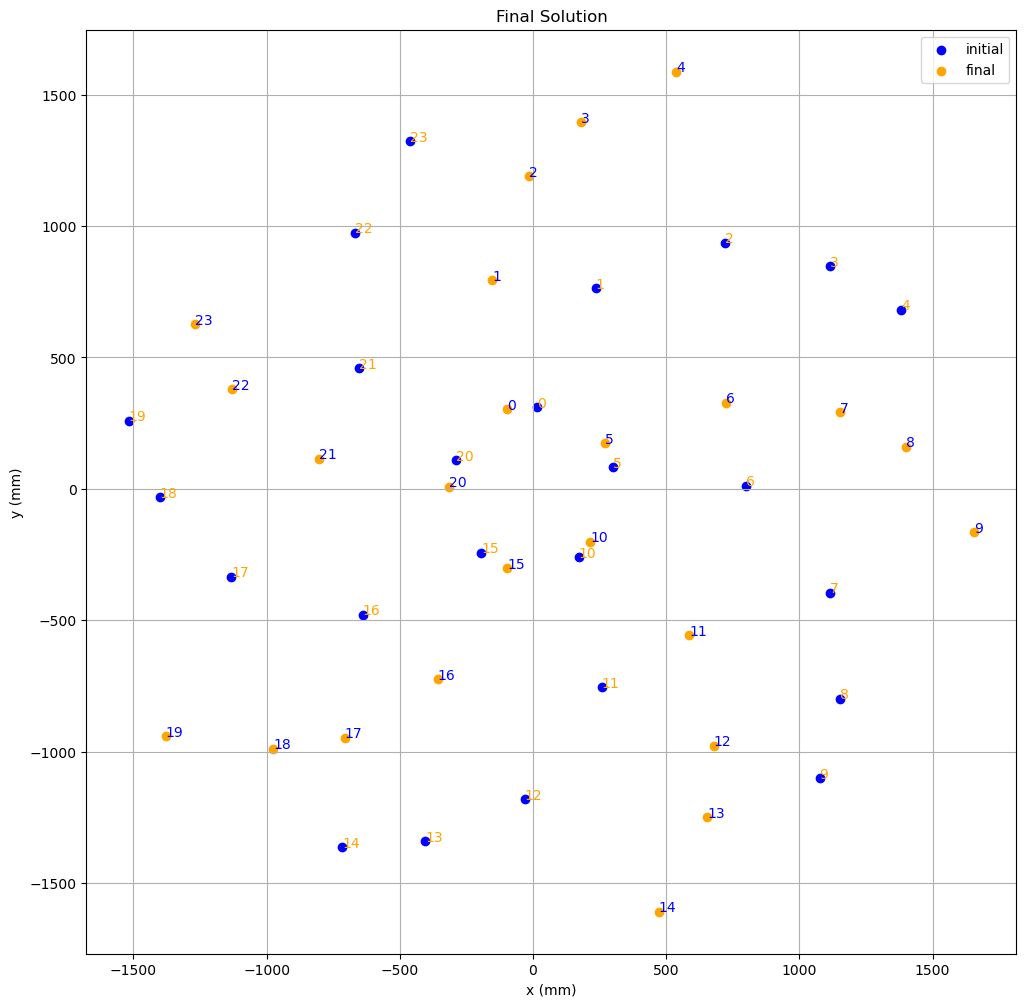

In [15]:
fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(pos_i[:,0], pos_i[:,1], label='initial', color='blue')
ax.scatter(pos[:,0], pos[:,1], label='final', color='orange')

for i in range(0,pos_i.shape[0]):
    ax.text(pos_i[i,0], pos_i[i,1],f"{i}", color='orange')

for i in range(0,pos.shape[0]):
    ax.text(pos[i,0], pos[i,1],f"{i}", color='blue')

ax.grid(True)
ax.set_title('Final Solution')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.legend()
plt.savefig('final_positions.png')
plt.show()

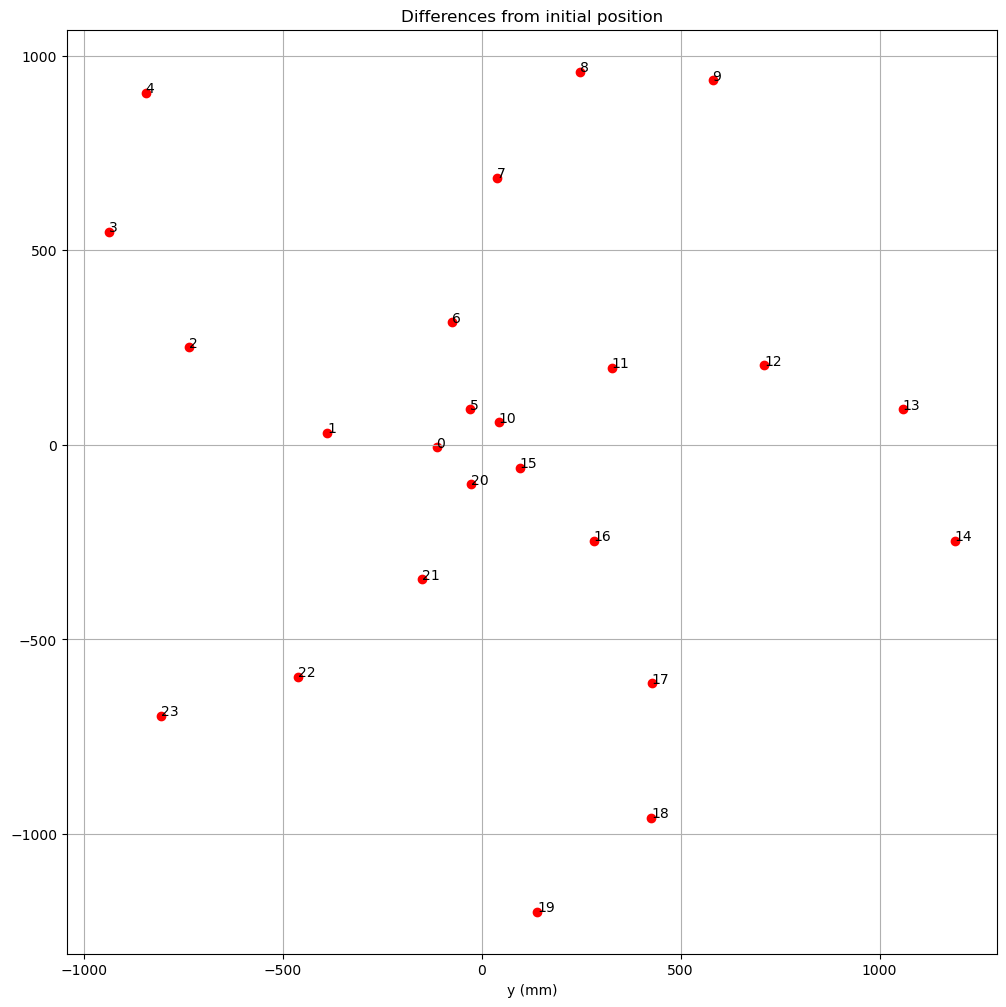

In [16]:
# Differences plot
diff = pos - pos_i[:,0:2]


fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(diff[:,0], diff[:,1], color='red')

for i in range(0,diff.shape[0]):
    ax.text(diff[i,0], diff[i,1],f"{i}")

ax.grid(True)
ax.set_title("Differences from initial position")
ax.set_xlabel('x (mm)')
ax.set_xlabel('y (mm)')
plt.savefig('differences.png')
plt.show()

In [17]:
# Residual plot
rres = radius_residual(res.x)
rres

A 0      4.726892
A 1      4.406532
A 2      1.303320
A 3      1.101949
A 4     -1.012472
A 5      6.708618
A 6     -7.935822
A 7      9.120485
A 8      7.669467
A 9     -3.748100
A 10   -19.240012
A 11     8.072823
A 12     6.969399
A 13     6.551381
A 14     3.372521
A 15     1.438779
A 16     8.566628
A 17     4.649828
A 18    -7.860980
A 19     3.986518
A 20    -3.226393
A 21     0.427828
A 22     2.789228
A 23     4.495354
Name: 0, dtype: float64

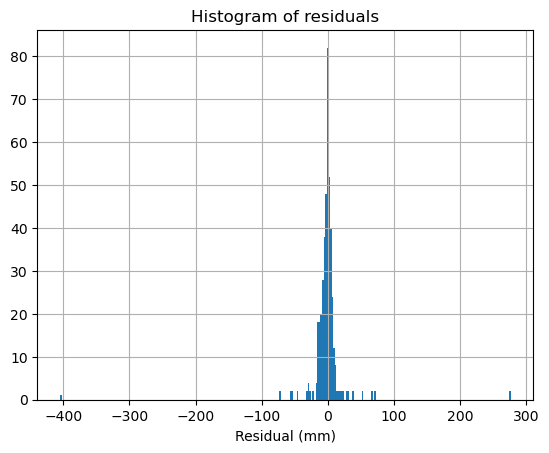

In [18]:
# ij resdual
ijres = m_ij_residual(res.x)
plt.hist(ijres, bins='fd');
plt.title("Histogram of residuals")
plt.xlabel("Residual (mm)")
plt.grid(True)
plt.savefig("residual_histogram.png")

The API expects 3D coordinates (with a z value which is zero in this case). Therefore we add a column of zeros.

In [19]:
absres = np.abs(ijres)
p95 = np.percentile(absres, 95)

print(f"95th percentile of residuals is {p95:4.2f} mm")
ijres_matrix = np.zeros_like(m_ij)
for r, i, j in zip(ijres, non_nan_indices[:,0], non_nan_indices[:,1]):
    if np.abs(r) > p95:
        print(f" res[{i},{j}] = {r:3.1f}")
    ijres_matrix[i,j] = r
    


95th percentile of residuals is 30.60 mm
 res[6,17] = 65.9
 res[8,10] = 52.6
 res[8,12] = -73.2
 res[9,9] = -405.0
 res[9,10] = 37.6
 res[9,18] = -32.7
 res[9,19] = 72.2
 res[10,8] = 52.6
 res[10,9] = 37.6
 res[10,15] = -53.3
 res[10,16] = -45.9
 res[10,17] = -55.2
 res[10,18] = 276.5
 res[12,8] = -73.2
 res[15,10] = -53.3
 res[16,10] = -45.9
 res[17,6] = 65.9
 res[17,10] = -55.2
 res[18,9] = -32.7
 res[18,10] = 276.5
 res[19,9] = 72.2


## Output best estimates

Write some json files...

In [20]:
result = np.zeros((n_ant, 3))
result[:,:-1] = np.round(pos/1000.0, 3)
result

array([[-0.099,  0.304,  0.   ],
       [-0.152,  0.795,  0.   ],
       [-0.013,  1.189,  0.   ],
       [ 0.18 ,  1.397,  0.   ],
       [ 0.537,  1.588,  0.   ],
       [ 0.269,  0.174,  0.   ],
       [ 0.723,  0.328,  0.   ],
       [ 1.152,  0.291,  0.   ],
       [ 1.398,  0.16 ,  0.   ],
       [ 1.656, -0.165,  0.   ],
       [ 0.214, -0.201,  0.   ],
       [ 0.585, -0.557,  0.   ],
       [ 0.678, -0.978,  0.   ],
       [ 0.654, -1.251,  0.   ],
       [ 0.472, -1.609,  0.   ],
       [-0.097, -0.301,  0.   ],
       [-0.357, -0.725,  0.   ],
       [-0.707, -0.947,  0.   ],
       [-0.975, -0.989,  0.   ],
       [-1.379, -0.94 ,  0.   ],
       [-0.317,  0.008,  0.   ],
       [-0.802,  0.114,  0.   ],
       [-1.129,  0.379,  0.   ],
       [-1.268,  0.627,  0.   ]])

In [21]:
json_result = {}
json_result["antenna_positions"] = result.tolist()

f = open("biust_antenna_positions.json", "w")
f.write(json.dumps(json_result))
f.close()

pos_json = json.dumps(json_result, indent=4, separators=(',', ': '))
print(pos_json)

{
    "antenna_positions": [
        [
            -0.099,
            0.304,
            0.0
        ],
        [
            -0.152,
            0.795,
            0.0
        ],
        [
            -0.013,
            1.189,
            0.0
        ],
        [
            0.18,
            1.397,
            0.0
        ],
        [
            0.537,
            1.588,
            0.0
        ],
        [
            0.269,
            0.174,
            0.0
        ],
        [
            0.723,
            0.328,
            0.0
        ],
        [
            1.152,
            0.291,
            0.0
        ],
        [
            1.398,
            0.16,
            0.0
        ],
        [
            1.656,
            -0.165,
            0.0
        ],
        [
            0.214,
            -0.201,
            0.0
        ],
        [
            0.585,
            -0.557,
            0.0
        ],
        [
            0.678,
            -0.978,
            0.0
  

The position file above is in a format suitable for uploading to the telescope api. Also for using as the calibrated_antenna_positions.json file in TART/software/containers/telescope_web_api/config_data.


    tart_upload_antenna_positions --api https://tart.elec.ac.nz/rhodes --pw=xxxx --file biust_antenna_positions.json
